In this notebook, we're going to talk about how we can segment time series data into smaller, more manageable chunks for analysis.


# Important: Run this code cell each time you start a new session!

In [4]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install ipywidgets
!pip install os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [5]:
!wget -Ncnp https://physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data/id00b70b13.csv

--2024-06-13 01:01:44--  https://physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data/id00b70b13.csv
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘id00b70b13.csv’ not modified on server. Omitting download.



In [6]:
df = pd.read_csv('id00b70b13.csv')

# Filter to only walking activity, which is given a code of 1
df = df[df['activity'] == 1]

# Process the time
df.rename(columns={'time_s': 'Time'}, inplace=True)
df = df[(df['Time']>=700) & (df['Time']<=710)]
df['Time'] = df['Time'] - df['Time'].min()

# Process the accel
df['Accel'] = np.sqrt(df['la_x']**2 + df['la_y']**2 + df['la_z']**2)*9.8

# Keep only crucial columns
keep_cols = ['Time', 'Accel']
df = df[keep_cols]
df.to_csv('walking.csv',index=False)

# What Is a Sliding Window?

A common approach to handling time-series data is to break it up into a sequence of data chunks, or ***windows***, and then analyzing those chunks rather than the entire sequence at once. Since windows are often generated sequentially over a signal, you will often hear them referred to as ***sliding windows***.

Basic data windowing requires deciding upon two important parameters:
1. **Width/length:** Describes how long the window is along the time axis.
2. **Stride:** Describes the temporal separation between successive windows.

The units of measurement for both of these parameters can be expressed in various ways:
1. **Time:** 5-second window with a 1-second stride
2. **Number of samples:** 100-sample window with a 20-sample stride
3. **Percentage:** 5-second window with a 1-second stride == (5-1)/5 = 80% overlap

As long we know the sampling rate of our signal, we can easily change between any of these units.

Let's write a function to manually slide a window along our signal assuming that we use the number of samples to define the window parameters:

In [7]:
def sliding_windows(x_values, y_values, width, stride):
    """
    x_values: the time component of the signal
    y_values: the measured value of the signal
    width: the width of the windows measured in # of samples
    stride: the stride of the windows measured in # of samples
    """
    # Initialize the start and end of the window
    start_idx = 0
    end_idx = width

    # Stop generating windows it would go past the end of the signal
    signal_length = df.shape[0]
    while end_idx < signal_length:
        # Grab the current window
        x_window = x_values.iloc[start_idx:end_idx]
        y_window = y_values.iloc[start_idx:end_idx]
        print("X data:", x_window.values)
        print("Y data:", y_window.values)
        print("============")

        # Move the window over by a stride
        start_idx += stride
        end_idx += stride

# Visualizing A Sliding Window

To see this algorithm in action, let's try it on a simple signal that we create on our own:



In [8]:
x = np.arange(1, 21)
y = np.array([0, 1, 2, 3, 3, 3, 3, 4, 5, 6,
              6, 5, 4, 3, 3, 3, 3, 2, 1, 0])
df = pd.DataFrame({'Time': x, 'Value': y})

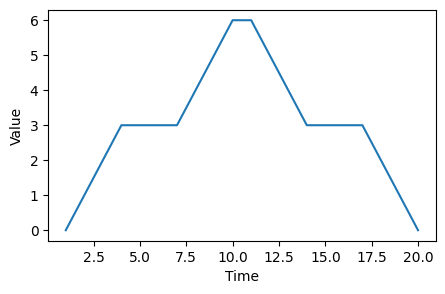

In [9]:
plt.figure(figsize=(5, 3))
plt.plot(df['Time'], df['Value'])
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Let's run the function we created earlier to see what windowing does:

In [10]:
sliding_windows(df['Time'], df['Value'], 5, 1)

X data: [1 2 3 4 5]
Y data: [0 1 2 3 3]
X data: [2 3 4 5 6]
Y data: [1 2 3 3 3]
X data: [3 4 5 6 7]
Y data: [2 3 3 3 3]
X data: [4 5 6 7 8]
Y data: [3 3 3 3 4]
X data: [5 6 7 8 9]
Y data: [3 3 3 4 5]
X data: [ 6  7  8  9 10]
Y data: [3 3 4 5 6]
X data: [ 7  8  9 10 11]
Y data: [3 4 5 6 6]
X data: [ 8  9 10 11 12]
Y data: [4 5 6 6 5]
X data: [ 9 10 11 12 13]
Y data: [5 6 6 5 4]
X data: [10 11 12 13 14]
Y data: [6 6 5 4 3]
X data: [11 12 13 14 15]
Y data: [6 5 4 3 3]
X data: [12 13 14 15 16]
Y data: [5 4 3 3 3]
X data: [13 14 15 16 17]
Y data: [4 3 3 3 3]
X data: [14 15 16 17 18]
Y data: [3 3 3 3 2]
X data: [15 16 17 18 19]
Y data: [3 3 3 2 1]


To make this concept a bit more clear, here is some code that provides an animated version of our manual implementation above. This code is a bit more complicated in order to make the animation work, so you can just focus on the end result for now.

In [11]:
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

def show_animated_window(x_values, y_values, width, stride,
                         show_points=True):
    # Calculate bounds
    xmin, xmax = min(x_values), max(x_values)
    ymin, ymax = min(y_values), max(y_values)

    # Create the figure and plot the line
    fig, ax = plt.subplots(figsize=(5, 3))
    linestyle = 'k-*' if show_points else 'k-'
    line, = ax.plot(x_values, y_values, linestyle)
    ax.set_xlim(xmin, xmax)
    ax.xaxis.set_ticks(np.arange(xmin, xmax+1, 1))

    # Calculate window parameters
    n = len(x_values)
    box_height = ymax - ymin
    box_width = x_values[width] - x_values[0]
    box_stride = x_values[stride] - x_values[0]
    num_windows = min(((n-width)//stride), 40) # cap the number of windows to 40

    # Create the animated box and add it to the graph
    box = plt.Rectangle((xmin, ymin), box_width, box_height,
                        fill=True, color='orange', alpha=0.5)
    ax.add_patch(box)

    # Calculate and update the new box position
    def update(frame):
        box.set_x(xmin+frame*box_stride)
        return [box]

    # Create the animation
    anim = animation.FuncAnimation(fig, update, frames=range(num_windows), interval=1000)
    return anim

Run the animation as it is currently set up (`window_width = 5` and `window_stride = 1`) to see how it aligns with the output of the `sliding_windows()` function we created earlier. After that, play around with the sliders to see how changing `window_width` and `window_stride` impacts the sliding window.

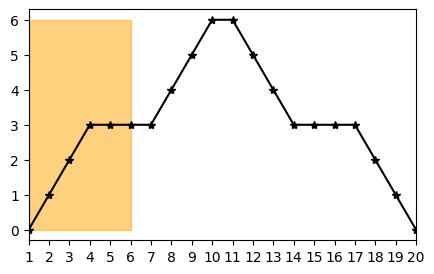

In [12]:
window_width = 5 #@param {type:"slider", min:1, max:5, step:1}
window_stride = 5 #@param {type:"slider", min:1, max:5, step:1}
show_animated_window(df['Time'], df['Value'], window_width, window_stride)

When we decrease `window_width`, the shaded area becomes narrower and the window contains fewer values with each iteration. When we increase `window_width`, the shaded area becomes wider and the window contains more values with each iterations.

When we decrease `window_stride`, the shaded area moves over the signal more gradually and consecutive windows will share more values. When we increase `window_stride`, the shaded area moves over the signal more aggressively and consectuive windows will share fewer values.

# Example with Sliding Windows: Peak Detection

Now that we know about sliding windows, let's go through an example to show how powerful they can be.

We are going to write an algorithm that is going to process motion data from a sensor strapped to a person's ankle and count the number of steps the person has taken. An example of the input to our algorithm is shown below:

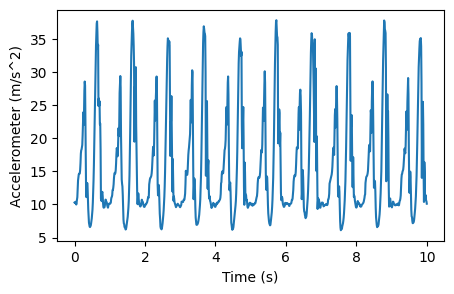

In [13]:
# Plot the data
df = pd.read_csv('walking.csv')
plt.figure(figsize=(5,3))
plt.plot(df['Time'], df['Accel'])
plt.xlabel('Time (s)')
plt.ylabel('Accelerometer (m/s^2)')
plt.show()

You might notice that this signal seems to have alternating peaks: a small one followed by a large one with roughly equal spacing. This is because we are measuring the motion of one foot during walking. The large peak corresponds to when the person steps with the same foot that has the sensor, and the smaller peak corresponds to when the person steps with the opposite foot.

Conceptually, our step-counting algorithm will incrementally slide a window across the signal, and update the step counter if the window contains a step (i.e., a peak in the accelerometer signal). The pseudocode for this algorithm is as follows:

```
initialize our window
initialize our step counter

while the window has not reached the end of the signal:
    grab the data within the window
    if there is a peak in the middle of the window:
        update our step counter
    move the window
```

For now, we are going to skip through some of the details and jump straight to the implementation.

In [14]:
def detect_steps(df, width, stride):
    """
    df: a DataFrame containing accelerometer values over time
    width: the width of the windows measured in # of samples
    stride: the stride of the windows measured in # of samples
    """
    # Initialize the start and end of the window
    start_idx = 0
    end_idx = width
    middle_idx = width // 2

    # NEW: Initialize the step counter
    steps = {}

    # Stop generating windows it would go past the end of the signal
    signal_length = df.shape[0]
    while end_idx < signal_length:
        # Grab the current window
        x_window = df['Time'].iloc[start_idx:end_idx]
        y_window = df['Accel'].iloc[start_idx:end_idx]

        # NEW: Check if there is a peak in the middle
        if y_window.argmax() == middle_idx:
            # NEW: Update the contents of the step counter
            step_timestamp = x_window.values[middle_idx]
            step_value = y_window.values[middle_idx]
            steps[step_timestamp] = step_value

        # Move the window over by a stride
        start_idx += stride
        end_idx += stride

    # NEW: Show the steps overlaid on the graph
    plt.figure(figsize=(5,3))
    plt.plot(df['Time'], df['Accel'])
    plt.plot(steps.keys(), steps.values(), 'k*')
    plt.xlabel('Time (s)')
    plt.ylabel('Accelerometer (m/s^2)')
    plt.title(f'Number of detected steps: {len(steps)}')
    plt.show()

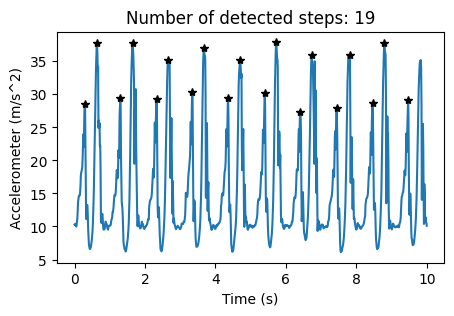

In [15]:
detect_steps(df, 50, 1)

Our algorithm isn't perfect, as you can see that we've missed the last step. We could fix this oversight by modifying our algorithm so that the window can effectively go past the end of the signal without throwing an exception, but we'll forgo that exercise for now.

## Deciding On Window Width

There were three major details that we skipped when writing our step-counting algorithm. Let's start with the first one:
1. How did we know to set `width = 50`?

To investigate this question, play around with the setting of `window_width` in the code block below.



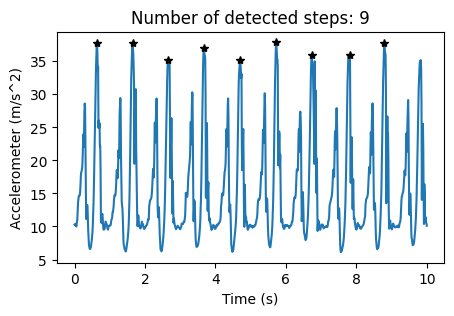

In [16]:
window_width = 100 #@param {type:"slider", min:10, max:100, step:10}
detect_steps(df, window_width, 1)

Notice that when the width is too narrow, the algorithm detects insignificant peaks between footsteps. When the width is too wide, the algorithm misses the more subtle steps by the non-dominant foot.

So how did we know that `window_size = 50` would work? This number came from two sources of information:
1. The **sampling rate** of the signal, which we can find out by inspecting the time-series or doing a bit of math:

In [17]:
time_diff = df['Time'].iloc[1] - df['Time'].iloc[0]
print(f"Sampling rate: {1/(time_diff):0.2f} Hz")

Sampling rate: 100.00 Hz


2. **Domain expertise** of knowing how quickly people typically walk. Using either our best guess or looking through literature, we can estimate that people take roughly 1-2 steps per second while walking.

If we assume a person takes 1 step per second, that means there will be `100 samples per second / 1 step per second = 100 samples per step` in our signal. If we assume a person takes 2 steps per second, that means there will be `100 samples per second / 2 steps per second = 50 samples per step` in our signal.

Recall that when we used the wider setting (100 samples), the window missed all the softer steps. Therefore, it makes to lean more toward the narrower windows as long as we don't go *too* narrow.

## Deciding On Window Stride

There were two other details we skipped over when writing our step-counting algorithm:
2. How did we know to set `stride = 1`?
3. Why did we only count a step if it happened exactly in the middle of the sliding window?

These two decisions went hand-in-hand for this particular algorithm, but first play around with the setting of window_stride in the code block below to see what happens.

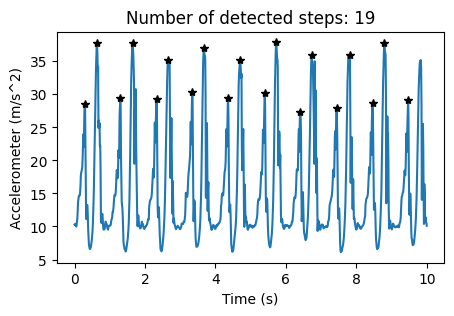

In [18]:
window_stride = 1 #@param {type:"slider", min:1, max:5, step:1}
detect_steps(df, 50, window_stride)

Since our algorithm is designed to detect peaks that land right in the middle of the window, setting the stride to the smallest unit possible ensures that every data point lands in the middle of a window at least once. By increasing the stride and not changing the requirement that the point lands in the middle, we miss peaks and undercount the number of steps taken.

Had we loosened the requirement about the peak landing in the middle of the window but used the smallest stride possible, we would have counted the same peak multiple times and inflated our step count.

As a compromise, we could change both the stride **AND** the requirement of where the peak landed within the window, but we will leave that as a thought exercise.

## Another Way To Write Our Algorithm

Knowing that the window parameters are tied to real-world time and that we want to check if there's a peak at every single point of our signal, we can actually rewrite our algorithm in a different way that only requires us to specify the window width in seconds:

In [19]:
def detect_steps(df, width):
    """
    df: a DataFrame containing accelerometer values over time
    width: the width of the windows measured in seconds
    """
    # Initialize the start and end of the window
    start_time = 0
    end_time = width

    # NEW: Calculate the sampling period and where the
    # middle index of the window will be
    sample_period = df['Time'].iloc[1] - df['Time'].iloc[0]
    middle_idx = int((width / sample_period) // 2)

    # Initialize the step counter
    steps = {}

    # Stop generating windows it would go past the end of the signal
    signal_duration = df['Time'].max()
    while end_time < signal_duration:
        # NEW: Grab the current window by filtering indexes according to time
        window_idxs = (df['Time'] >= start_time) & (df['Time'] <= end_time)
        x_window = df['Time'][window_idxs]
        y_window = df['Accel'][window_idxs]

        # Check if there is a peak in the middle
        if y_window.argmax() == middle_idx:
            # Update the contents of the step counter
            step_timestamp = x_window.values[middle_idx]
            step_value = y_window.values[middle_idx]
            steps[step_timestamp] = step_value

        # Move the window over by a stride
        start_time += sample_period
        end_time += sample_period

    # Show the steps overlaid on the graph
    plt.figure(figsize=(5,3))
    plt.plot(df['Time'], df['Accel'])
    plt.plot(steps.keys(), steps.values(), 'k*')
    plt.xlabel('Time (s)')
    plt.ylabel('Accelerometer (m/s^2)')
    plt.title(f'Number of detected steps: {len(steps)}')
    plt.show()

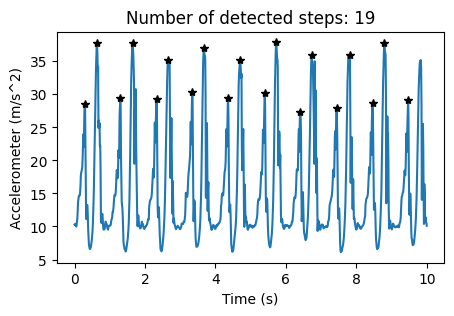

In [20]:
detect_steps(df, 0.5)

# General Guidelines for Sliding Windows

**Window Width**
* Longer windows are better at accounting for long-term trends.
* Shorter windows are better at accounting for short-term trends.

**Window Stride**
* Longer window strides will decrease the temporal resolution of your analysis but make your analysis more efficient.
* Shorter window strides will increase the temperal resolution of your analysis but may result in redundant calculations if the signal is stagnant over time.

**Window Width and Stride**
* The window stride almost never exceeds the window width. Otherwise, this would cause some parts of the signal to never be included in any window.
* Having the window width and the window stride being set to the same value essentially splits up your data into distinct, non-overlapping segments. In some cases, samples at the boundaries may be handled incorrectly (e.g., peak detection).
* Common window configurations typically involve overlap percentages like 90%, 75%, and 50% that ensure every sample is seen the same number of times.

All in all, you will need to use a combination of domain expertise, intuition, and trial-and-error to determine a reasonable configuration for a sliding window. You will rarely need to be super precise with how you construct your sliding window; otherwise, your analysis plan is probably too fragile to generalize to other scenarios. Still, thinking about how to subdivide time-series data into managable chunks will help as you prepare for downstream analyses like machine learning.